In [30]:
'''Refernce: https://www.kaggle.com/donpiano/keras-resnet-50-for-pneumonia-x-ray-images'''

# Importing all the necessary packages/libraries

from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tracemalloc
from pytictoc import TicToc

from glob import glob
import os
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import cv2

import matplotlib.pyplot as plt

In [31]:
# Building pre-trained RESNET50 model

num_classes = 1

resnet_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5' # Pre-trained weights for image classification

model = Sequential()

model.add(ResNet50(include_top=False, pooling='max', weights=resnet_weights_path)) # Not using default fully-connected layers 

model.add(Dense(num_classes, activation='sigmoid')) # Adding fully-connected layer for binary classification

model.layers[0].trainable = False # Freezing layers using pre-trained weights

# Compiling built model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Assigning hyperparameter values

image_size = 150
nb_train_samples = 5216 
batch_size = 32

EPOCHS = 6
STEPS = nb_train_samples / batch_size

# Image augmentation using ImageDataGenerator from KERAS

data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                             horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2
                                            )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input            
                                          )

train_generator = data_generator_with_aug.flow_from_directory(
       directory = 'chest-xray-pneumonia//chest_xray//train/',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'binary')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = 'chest-xray-pneumonia//chest_xray//val/',
       target_size = (image_size, image_size),
       class_mode = 'binary')

test_generator = data_generator_no_aug.flow_from_directory(
       directory = 'chest-xray-pneumonia//chest_xray//test/',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [34]:
t1 = TicToc()

tracemalloc.start()

t1.tic()

# Model training using training dataset from data augmentation function

model.fit_generator(
       train_generator, # specify where model gets training data
       epochs = EPOCHS,
       steps_per_epoch=STEPS,
       validation_data=validation_generator) # specify where model gets validation data

t1.toc('ResNet50 - Time taken for training -- ')

snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('traceback')

# pick the biggest memory block
stat = top_stats[0]
print("ResNet50 - Memory for Training --%s memory blocks: %.1f KiB" % (stat.count, stat.size / 1024))

Epoch 1/6
163/163 [==============================] - 876s 5s/step - loss: 0.5701 - accuracy: 0.8489 - val_loss: 0.5666 - val_accuracy: 0.7500
Epoch 2/6
163/163 [==============================] - 833s 5s/step - loss: 0.2841 - accuracy: 0.9164 - val_loss: 1.6007 - val_accuracy: 0.6250
Epoch 3/6
163/163 [==============================] - 872s 5s/step - loss: 0.2768 - accuracy: 0.9181 - val_loss: 0.4916 - val_accuracy: 0.8125
Epoch 4/6
163/163 [==============================] - 872s 5s/step - loss: 0.2680 - accuracy: 0.9231 - val_loss: 0.9047 - val_accuracy: 0.6875
Epoch 5/6
163/163 [==============================] - 880s 5s/step - loss: 0.2658 - accuracy: 0.9300 - val_loss: 1.5701 - val_accuracy: 0.5625
Epoch 6/6
163/163 [==============================] - 873s 5s/step - loss: 0.2207 - accuracy: 0.9367 - val_loss: 0.3465 - val_accuracy: 0.8125
ResNet50 - Time taken for training --  5216.035301 seconds.
ResNet50 - Memory for Training --870 memory blocks: 433506.2 KiB

accuracy: 86.06%


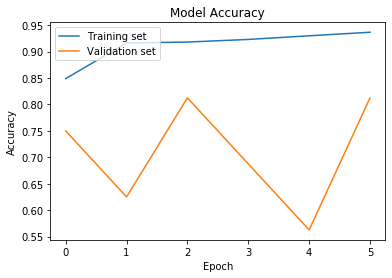

In [36]:
# Accuracy 
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

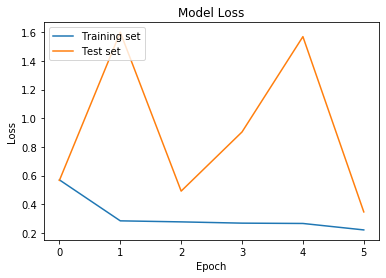

In [37]:
# Loss 
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Creating test arrays and labels to evaluate model performance using accuracy metrics

test_data = []
test_labels = []

img_dims = 150

input_path  = 'chest-xray-pneumonia//chest_xray/'

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'test' + cond)):
        img = plt.imread(input_path+'test'+cond+img)
        img = cv2.resize(img, (img_dims, img_dims))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        if cond=='/NORMAL/':
            label = 0
        elif cond=='/PNEUMONIA/':
            label = 1
        test_data.append(img)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

t1 = TicToc()

tracemalloc.start()

t1.tic()

# Model prediction on test data

preds = model.predict(test_data)

t1.toc('ResNet50 - Time taken for predicitng -- ')

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

# Model evaluation using accuracy metrics

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

ResNet50 - Time taken for predicitng --  97.308830 seconds.
CONFUSION MATRIX ------------------
[[  0 234]
 [  0 390]]

TEST METRICS ----------------------
Accuracy: 62.5%
Precision: 62.5%
Recall: 100.0%
F1-score: 76.92307692307692
